# Machine Learning Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 


---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))


There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

(250, 250)
Number of faces detected: 1


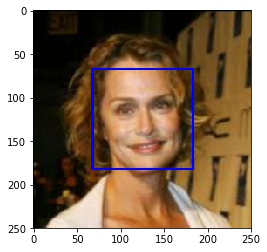

In [3]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline  




# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
#img = cv2.imread('images/me_pic.jpg')
#img = cv2.imread('dogImages/train/008.American_staffordshire_terrier/American_staffordshire_terrier_00578.jpg')

# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(gray.shape)

# find faces in image
faces = face_cascade.detectMultiScale(gray)
#faces = face_cascade.detectMultiScale(img)


# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()


Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0



### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

dog_targets_short= train_targets[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
def face_counter(imgs):
    count=0
    for i in range(len(imgs)):
        if face_detector(imgs[i]):
            count+=1
    return count
            
print('The percent of human faces detected: ', face_counter(human_files_short))

print('The percent of human faces detected from dog images: ', face_counter(dog_files_short))


The percent of human faces detected:  98
The percent of human faces detected from dog images:  11


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

**

I do not think it is unreasonable to communicate to the user that we need a clear view of a face to get good results. Additionally to reduce the user frustration we could use a combination of the haarcascade detectors to increasing true positives  and reduce false positives of our face_detector.

I tried many of the haarcascade detectors individually. A way to detect more faces form unclear images would be to include images with a profile. Also, I found a combniation of frontalface_alt, frontalface_alt2, frontalface_default, and profile detectors gave the best results.

This increased the true positive(form 98 to 99) and decreased false positives(from 11 to 9) compared to using the frontalface_alt detector alone. This would decrease user frustration.



In [6]:
face_cascade_frontal_alt2 = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt2.xml')
face_cascade_frontal_alt = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
face_cascade_default = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')
face_cascade_frontal_alt_tree = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt_tree.xml')
face_cascade_profile = cv2.CascadeClassifier('haarcascades/haarcascade_profileface.xml')
face_cascade_eye = cv2.CascadeClassifier('haarcascades/haarcascade_eye.xml')
face_cascade_fullbody = cv2.CascadeClassifier('haarcascades/haarcascade_fullbody.xml')
cascade_lowerbody = cv2.CascadeClassifier('haarcascades/haarcascade_lowerbody.xml')
face_cascade_smile = cv2.CascadeClassifier('haarcascades/haarcascade_smile.xml')

### Individual Detector Results


Result for haarcascade_frontalface_alt:
    The percent of human faces detected:  98
    The percent of human faces detected from dog images:  11
    
Result for haarcascade_frontalface_alt2:
    The percent of human faces detected:  99
    The percent of human faces detected from dog images:  20

Result for haarcascade_frontalface_default:
    The percent of human faces detected:  100
    The percent of human faces detected from dog images:  58
    
Result for haarcascade_frontalface_alt_tree:
    The percent of human faces detected:  50
    The percent of human faces detected from dog images:  1

Result for haarcascade_eye:
    The percent of human faces detected:  96
    The percent of human faces detected from dog images:  69
    
Result for haarcascade_fullbody:
    The percent of human faces detected:  0
    The percent of human faces detected from dog images:  7

Result for haarcascade_lowerbody:
    The percent of human faces detected:  0
    The percent of human faces detected from dog images:  5

Result for haarcascade_upperbody:
    The percent of human faces detected:  6
    The percent of human faces detected from dog images:  17

Result for haarcascade_smile:
    The percent of human faces detected:  100
    The percent of human faces detected from dog images:  100
    
Result for haarcascade_profile:
    The percent of human faces detected:  39
    The percent of human faces detected from dog images:  2


In [7]:
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    faces_frontal_alt = face_cascade_frontal_alt.detectMultiScale(gray)
    faces_frontal_alt2 = face_cascade_frontal_alt2.detectMultiScale(gray)
    faces_frontal_default = face_cascade_default.detectMultiScale(gray)
    faces_eye = face_cascade_eye.detectMultiScale(gray)
    faces_profile = face_cascade_profile.detectMultiScale(gray)
    
    #return len(faces_profile) > 0
    #return len(faces_frontal_alt) > 0 and len(faces_frontal_alt2) > 0 and len(faces_frontal_default)#98,7
    #return (len(faces_frontal_alt) > 0 and len(faces_frontal_alt2) > 0 and len(faces_frontal_default) and len(faces_eye) > 0)#95,5
    #return (len(faces_frontal_alt) > 0 and len(faces_frontal_alt2) > 0 and len(faces_frontal_default) and len(faces_eye) > 0) or len(faces_profile) > 0#97,7
    return (len(faces_frontal_alt) > 0 and len(faces_frontal_alt2) > 0 and len(faces_frontal_default) ) or len(faces_profile) > 0#
    #return len(faces_frontal_alt) > 0  and len(faces_eye) > 0#95,7

In [8]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
def face_counter(imgs):
    count=0
    for i in range(len(imgs)):
        if face_detector(imgs[i]):
            count+=1
    return count
            
print('The percent of human faces detected: ', face_counter(human_files_short))

print('The percent of human faces detected from dog images: ', face_counter(dog_files_short))


The percent of human faces detected:  99
The percent of human faces detected from dog images:  9


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [9]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [10]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    #print(list_of_tensors.shape)
    
    return np.vstack(list_of_tensors)


### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [11]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))


### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [12]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 


### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [13]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

def dog_counter(imgs):
    count=0
    for i in range(len(imgs)):
        if dog_detector(imgs[i]):
            count+=1
    return count
            
print('The percent of dog breads detected from human images: ', dog_counter(human_files_short))

print('The percent of dog breads detected from dog images: ', dog_counter(dog_files_short))



The percent of dog breads detected from human images:  1
The percent of dog breads detected from dog images:  100


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel

Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador


We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [14]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:13<00:00, 87.50it/s]


In [15]:
#Image Augmentation Configuration
from keras.preprocessing.image import ImageDataGenerator

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        #rescale=1./255, # Done above
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

valid_datagen = ImageDataGenerator(
        #rescale=1./255, # Done above
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)


train_datagen.fit(train_tensors)
valid_datagen.fit(valid_tensors)

### (IMPLEMENTATION) Model Architecture
         
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__  I used the cnn that was referenced in Udacity Deep Learning Lesson 1 video 17(1). I used this cnn because it worked well in the cifar 10 data example that used categorical classifications. This is similar to what we need here to create a dog breed classification. I adapted the last dense layer to accommodate 133 dog breed classifications.

This cnn starts with 3 convolutional layer and each is followed by a maxpooling layer. Then there is a dropout layer. Then the array is fattened. This is followed by two dense layers separated by another dropout layer.  

I tested this with and without the dropout layers. I also tested this by adding a 4th convolutional layer with and without dropout layers. In all testing I used data augmentation. I thought data augmentation would "prevent overfitting  and helps the model generalize".(2) 

As shown below the best result came from the model with '4 convolutional layers with dropout' with a test accuracy: 7.4163% This is above the minimum goal of 1% accuracy for this step.


In [17]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

In [18]:
# Define architecture.
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 16)      1040      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 64)        0         
__________

### Compile the Model

In [19]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [20]:
from keras.callbacks import ModelCheckpoint  

epochs = 3
batch_size = 16

checkpointer = ModelCheckpoint(filepath='saved_models/weights_AUGMENTED.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit_generator(train_datagen.flow(train_tensors, train_targets, batch_size=batch_size),
                    validation_data=valid_datagen.flow(valid_tensors, valid_targets), 
                    validation_steps=valid_tensors.shape[0] // batch_size,
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, callbacks=[checkpointer], verbose=1)

Epoch 1/3
417/417 [==============================] - 415s - loss: 4.8493 - acc: 0.0139 - val_loss: 4.6614 - val_acc: 0.0330
Epoch 2/3
417/417 [==============================] - 409s - loss: 4.4876 - acc: 0.0409 - val_loss: 4.3355 - val_acc: 0.0548
Epoch 3/3
417/417 [==============================] - 412s - loss: 4.2653 - acc: 0.0588 - val_loss: 4.2584 - val_acc: 0.0523


### Load the Model with the Best Validation Loss

In [21]:
model.load_weights('saved_models/weights_AUGMENTED.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [22]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 6.4593%


### 3 and 4 conv Layers With and Without Dropout Results
3 convoluted layers no dropout - Test accuracy: Test accuracy: 6.9378%
3 convoluted layers with dropout: Test accuracy: Test accuracy: 7.0574%

4 convluted layers no dropout - Test accuracy: Test accuracy: 6.6986%
4 convluted layers with dropout - Test accuracy: Test accuracy: 7.4163%

---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [23]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [24]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [25]:
from keras.optimizers import Adam, Adamax, SGD

#VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#VGG16_model.compile(loss='categorical_crossentropy', optimizer=Adamax(lr=0.002), metrics=['accuracy'])
VGG16_model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.0001, momentum=0.9), metrics=['accuracy'])



### Train the Model

In [26]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=30, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s - loss: 13.0104 - acc: 0.0407 - val_loss: 11.3730 - val_acc: 0.0910
Epoch 2/20
6680/6680 [==============================] - 0s - loss: 10.0587 - acc: 0.1448 - val_loss: 9.1247 - val_acc: 0.1820
Epoch 3/20
6680/6680 [==============================] - 0s - loss: 8.2225 - acc: 0.2467 - val_loss: 7.8608 - val_acc: 0.2587
Epoch 4/20
6680/6680 [==============================] - 0s - loss: 7.0406 - acc: 0.3210 - val_loss: 6.9025 - val_acc: 0.3078
Epoch 5/20
6680/6680 [==============================] - 0s - loss: 6.0798 - acc: 0.3772 - val_loss: 6.1404 - val_acc: 0.3413
Epoch 6/20
6680/6680 [==============================] - 0s - loss: 5.3421 - acc: 0.4344 - val_loss: 5.5922 - val_acc: 0.4036
Epoch 7/20
6680/6680 [==============================] - 0s - loss: 4.8460 - acc: 0.4826 - val_loss: 5.2889 - val_acc: 0.4240
Epoch 8/20
6680/6680 [==============================] - 0s - loss: 4.5045 -

### Load the Model with the Best Validation Loss

In [27]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [28]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 59.0909%


### Changing the Opitmizer  and Batch Size
batch size 20

- optimizer='rmsprop':  val_acc: 0.4515
- optimizer=Adamax(lr=0.002):  val_acc: 0.4707 
- optimizer=SGD(lr=0.0001, momentum=0.9):  val_acc: 0.5964   

batch size 30

- optimizer='rmsprop': val_acc: 0.4443
- optimizer=Adamax(lr=0.002): val_acc: 0.4096
- optimizer=SGD(lr=0.0001, momentum=0.9): val_acc: 0.6228 * best validation result

### Predict Dog Breed with the Model

In [29]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [30]:
print(dog_files_short[0])

dogImages/train/095.Kuvasz/Kuvasz_06442.jpg


In [31]:
VGG16_predict_breed(dog_files_short[0])

'Kuvasz'

This prediction is correct because it matches the breed name in the input image file path.

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [55]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
#bottleneck_features = np.load('bottleneck_features/DogInceptionV3Data.npz')
bottleneck_features = np.load('bottleneck_features/DogXceptionData.npz')
#bottleneck_features = np.load('bottleneck_features/DogVGG19Data.npz')
#bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')


train_Xception = bottleneck_features['train']
valid_Xception = bottleneck_features['valid']
test_Xception = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

Steps to build CNN:
- 1) Down load pretrained bottleneck_features from networks.
- 2) Create train, valid and test for all bottle neck features and pick the best validation result. As shown below all bottle neck features networks were tested with varying number of epochs, batch size and optimizers. The best validation accuracy resulted from a model with 30 epochs, batch size of 17 and an Adamax(lr=0.002) optimizer.
- 3) Create a Xception_model
- 4) Add a GlobalAveragePooling2D layer.
- 5) Add a Dense Layer with an entry for each of the 133 object classes in the data.(1) 


As shown below many models were attempted. I believe the reason why the model with Xception and optimizer of Adamax(lr=0.002) is the best architecture is because it has the best "entropic capacity"(2) and the best learning rate for transfer learning with fine tuning. "how much information the model is allowed to store"(2) is the entropic capacity. Xception has the best number of layers and size of layers and type of layers to best capture more information about the images compared to Inception, Resnet50, VGG19. Additionally we see that 'rmsprop' is usually the optimaiser with the worst accuracy. For fine tuning after transfer learning we need a small learning rate. Since we are using transfer learning a large learning rate would "wreck the previously learned features"(2).  Apparently 'rmsprop' uses an adaptive learning rate, large learning rate at first and then a smaller learning rate. This could explain why the 'rmsprop' is usually the optimizer with the worst accuracy.  So I believe the reason this model has the best architecture is because it can hold the most information about the image and it has the best learning rate to fine tune the features in all the models tested below.  

### (IMPLEMENTATION) Compile the Model

In [56]:
### TODO: Define your architecture.
Xception_model = Sequential()
Xception_model.add(GlobalAveragePooling2D(input_shape=train_Xception.shape[1:]))

Xception_model.add(Dense(133, activation='softmax'))

Xception_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 133)               272517    
Total params: 272,517.0
Trainable params: 272,517.0
Non-trainable params: 0.0
_________________________________________________________________


In [57]:
### TODO: Compile the model.
#Xception_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
Xception_model.compile(loss='categorical_crossentropy', optimizer=Adamax(lr=0.002), metrics=['accuracy'])
#Xception_model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.002, momentum=0.9), metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [58]:
from keras.callbacks import ModelCheckpoint 

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
                               verbose=1, save_best_only=True)

Xception_model.fit(train_Xception, train_targets, 
          validation_data=(valid_Xception, valid_targets),
          epochs=30, batch_size=17, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/30
6680/6680 [==============================] - 30s - loss: 1.2883 - acc: 0.7051 - val_loss: 0.6538 - val_acc: 0.8299
Epoch 2/30
6680/6680 [==============================] - 5s - loss: 0.4924 - acc: 0.8728 - val_loss: 0.5354 - val_acc: 0.8515
Epoch 3/30
6680/6680 [==============================] - 6s - loss: 0.3753 - acc: 0.9031 - val_loss: 0.4849 - val_acc: 0.8575
Epoch 4/30
6680/6680 [==============================] - 6s - loss: 0.3054 - acc: 0.9192 - val_loss: 0.4589 - val_acc: 0.8695
Epoch 5/30
6680/6680 [==============================] - 6s - loss: 0.2549 - acc: 0.9356 - val_loss: 0.4565 - val_acc: 0.8671
Epoch 6/30
6680/6680 [==============================] - 6s - loss: 0.2181 - acc: 0.9451 - val_loss: 0.4471 - val_acc: 0.8599
Epoch 7/30
6680/6680 [==============================] - 6s - loss: 0.1879 - acc: 0.9554 - val_loss: 0.4365 - val_acc: 0.8647
Epoch 8/30
6680/6680 [==============================] - 6s - loss: 0.1629 - a

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [59]:
### TODO: Load the model weights with the best validation loss.
Xception_model.load_weights('saved_models/weights.best.Xception.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [60]:
### TODO: Calculate classification accuracy on the test dataset.
Xception_predictions = [np.argmax(Xception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Xception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_targets, axis=1))/len(Xception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 86.0048%


###  Optimizer, Batch size and Epochs Evaluations
VGG19 - epochs=30, batch_size=25
- optimizer='rmsprop': val_acc: 0.4898
- optimizer=Adamax(lr=0.002): val_acc: 0.5150
- optimizer=SGD(lr=0.002, momentum=0.9): val_acc: 0.4491

Resnet50 - epochs=30, batch_size=25
- optimizer='rmsprop': val_acc: 0.8263
- optimizer=Adamax(lr=0.002): val_acc: 0.8359
- optimizer=SGD(lr=0.002, momentum=0.9): val_acc: 0.8335

Xception - epochs=30, batch_size=17
- optimizer='rmsprop': val_acc: 0.8587
- optimizer=Adamax(lr=0.002): val_acc: 0.8635   <------------- Best Validation Results ( results will vary slightly) 
- optimizer=SGD(lr=0.002, momentum=0.9): val_acc: 0.8599  
- optimizer=SGD(lr=0.001, momentum=0.9): val_acc: 0.8551

Xception - epochs=30, batch_size=20
- optimizer='rmsprop': val_acc: 0.8503
- optimizer=Adamax(lr=0.002):  val_acc: 0.8613
- optimizer=SGD(lr=0.002, momentum=0.9): val_acc: 0.8551

Xception - epochs=30, batch_size=25 
- optimizer='rmsprop': val_acc: 0.8443
- optimizer=Adamax(lr=0.002): val_acc: 0.8619
- optimizer=SGD(lr=0.002, momentum=0.9): val_acc: 0.8563

Inception - epochs=20, batch_size=20
- optimizer='rmsprop': val_acc: 0.8587
- optimizer=Adamax(lr=0.0002):  val_acc: 0.8599
- optimizer=Adamax(lr=0.002): val_acc: 0.8611 

- optimizer=SGD(lr=0.0001, momentum=0.9): val_acc: 0.8371      
- optimizer=SGD(lr=0.002, momentum=0.9): val_acc: 0.8611  
- optimizer=SGD(lr=0.01, momentum=0.9): val_acc: 0.8599

Inception - epochs=30, batch_size=17
- optimizer='rmsprop': val_acc: 0.8491
- optimizer=Adamax(lr=0.002): val_acc: 0.8599
- optimizer=SGD(lr=0.002, momentum=0.9):  val_acc: 0.8551

Inception - epochs=30, batch_size=20
- optimizer='rmsprop': val_acc: 0.8491 
- optimizer=Adamax(lr=0.002): val_acc: 0.8599
- optimizer=SGD(lr=0.002, momentum=0.9): val_acc: 0.8611
 
Inception - epochs=30, batch_size=25
- optimizer='rmsprop': val_acc: 0.8479
- optimizer=Adamax(lr=0.002): val_acc: 0.8611
- optimizer=SGD(lr=0.002, momentum=0.9): val_acc: 0.8575

Outline:
- Get bottleneck_features
- Define your architecture
- Compile the model
- Train the model
- Load model weights with best val_loss
- Test model on test set

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [39]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

from extract_bottleneck_features import *

def Xception_predict_breed(img_path):
    #using bottelneck_features from above
    bottleneck_feature = extract_Xception(path_to_tensor(img_path))
    predicted_vector = Xception_model.predict(bottleneck_feature)
    return dog_names[np.argmax(predicted_vector)]


#InceptionV3_predict_breed(train_files[0])
Xception_predict_breed(train_files[3])

'American_staffordshire_terrier'

In [40]:
print(train_files[3])

dogImages/train/008.American_staffordshire_terrier/American_staffordshire_terrier_00596.jpg


This prediction is correct because it matches the breed name in the input image file path.

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  


### (IMPLEMENTATION) Write your Algorithm

In [41]:
###Redefine the Dog Detector increase robustness.

In [42]:
# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    #print(list_of_tensors.shape)
    return np.vstack(list_of_tensors)

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

def dog_counter(imgs):
    count=0
    for i in range(len(imgs)):
        if dog_detector(imgs[i]):
            count+=1
    return count

In [46]:
import glob

def final_algorithm(file_path):
    #Is dog image?
    print("\n\n")
    print(file_path, "file_path")
    if dog_detector(file_path):
        print("Hello dog")
        breed = Xception_predict_breed(file_path)
        files = glob('dogImages/train/***.' + breed +'/'+breed + '_*****.jpg')                
        plt.figure(1)
        plt.subplot(121)
        plt.title('Dog Image')
        img1 = cv2.imread(file_path)
        cv_rgb1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        plt.imshow(cv_rgb1)
        #Randomly select one image from the predicted breeds training images to compare.
        img2 = cv2.imread(files[random.randrange(0, len(files), 1) ])
        cv_rgb2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        plt.subplot(122)
        plt.title('Example of Predicted Breed')
        plt.imshow(cv_rgb2)
        plt.show()         
        print("Your breed is likely: ", breed) 
       
    #Is human face in image?
    elif face_detector(file_path):
        print("Hello human!")
        breed = Xception_predict_breed(file_path)
        files = glob('dogImages/train/***.' + breed +'/'+breed + '_*****.jpg')                    
        plt.figure(1)
        plt.subplot(121)
        plt.title('Face Image')
        img1 = cv2.imread(file_path)
        cv_rgb1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        plt.imshow(cv_rgb1)
        #randomly select one image from the predicted breeds training imagesto compare.
        img2 = cv2.imread(files[random.randrange(0, len(files), 1) ])
        cv_rgb2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        plt.subplot(122)
        plt.title('Example of Predicted Breed')
        plt.imshow(cv_rgb2)
        plt.show()
        print("You look like a: ", breed) 
    #Is neither a human or dog in image?    
    else:
        print("Hello Neither Human or Dog!")
        breed = Xception_predict_breed(file_path)
        print(breed)
        files = glob('dogImages/train/***.' + breed +'/'+breed + '_*****.jpg')                
        plt.figure(1)
        plt.subplot(121)
        plt.title('Neither Human or Dog Image')
        img1 = cv2.imread(file_path)
        cv_rgb1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        plt.imshow(cv_rgb1)
        #randomly select one image from the predicted breeds training images to compare.
        img2 = cv2.imread(files[random.randrange(0, len(files), 1) ])
        cv_rgb2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        plt.subplot(122)
        plt.title('Example of Predicted Breed')
        plt.imshow(cv_rgb2)
        plt.show()
        print("This image(neither human or dog) most resembles a: ", breed) 

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

The output below is in the range of what was expected.  The algorithm correctly predicted 'Dog', 'Human' or 'Neither' in every case. Of the dog images in the 'algorithm test set' with definitive known breeds had an accuracy similar to the 'test set' accuracy above. Since I have many dogs in my extended family that I wanted to include only 8 of the 10 dog images had known definitive breeds. Of the 8 dogs with known breeds 6 were predicted correct by the algorithm 75%. The other two were predicted partially correct. The jack_russell_terrier was predicted to be a parson_russell_terrier. Goerge the basset_hound appeared twice and one image was predicted partially correct as American_foxhound. The 'algorithms test accuracy' of of 75% is similar to the 'test set' accuracy above of about 86%.

Other images were added to the 'algorithm test set' that were human faces or 'neither' human or dog. Of these there were a bear, fox and a mop. After I stopped laughing at the dog that looks like a mop and the dog that looks like Donald Trumps frowning image I realized the algorithm is predicting the best it can based on shapes and colors. For example the fox looks like a  Norwegian_lundehund that has similar color and ear shape. Even the Donald Trump frown looks similar to the shape of the Petit_basset_griffon_vendeen mouth area.

Moving foward this model may be improved by a the following ideas. First improve the face_detector above. Although here the algorithm correctly detected 'Dog', 'Human' or 'Neither', in every case, above it predicted 11 out of 100 dog images as a human face image.
Another way to improve the algorithm would be to use a data generator. This would increase the number of input samples by creating new images from an input image by varying the shear_range,
zoom_range and horizontally flipping the image. Also, getting more known dog breed images from many different angles would improve the algorithm.

This project shows the predictive power of a convolutional neural network. It does have its limitations. For example I do not look like a Dachshund. That's me in the blue shirt. The 'not dog images' shows us a little about how the algorithm predicts based on shapes and colors. Even with a limited data set this algorithm was able to get a 86.0048% on the 'test set' above.

In [47]:
def tester(imgs):
    for i in range(len(imgs)):
        #dog_detector(imgs[i])
        final_algorithm(imgs[i])

There are 16 total testrun_files images.



testrun/grey_hound2.jpg file_path
Hello dog


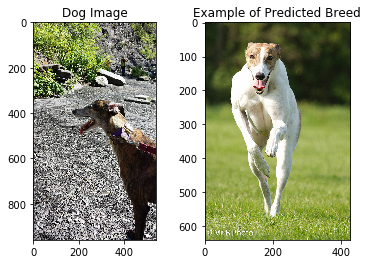

Your breed is likely:  Greyhound



testrun/fox1.jpeg file_path
Hello Neither Human or Dog!
Norwegian_lundehund


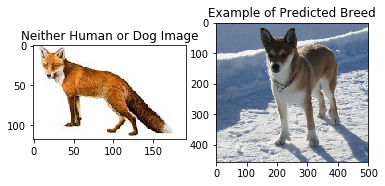

This image(neither human or dog) most resembles a:  Norwegian_lundehund



testrun/buttercup.jpg file_path
Hello dog


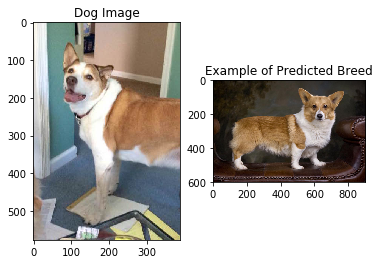

Your breed is likely:  Pembroke_welsh_corgi



testrun/George2.jpg file_path
Hello dog


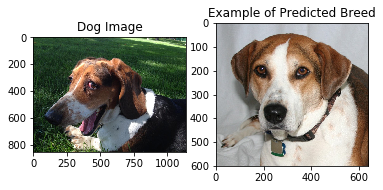

Your breed is likely:  American_foxhound



testrun/Cavalier-King-Charles-Spaniel-1.jpg file_path
Hello dog


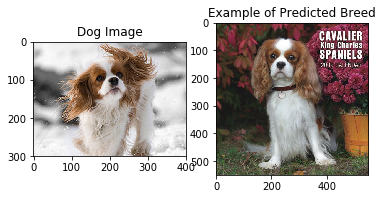

Your breed is likely:  Cavalier_king_charles_spaniel



testrun/trump3.jpeg file_path
Hello human!


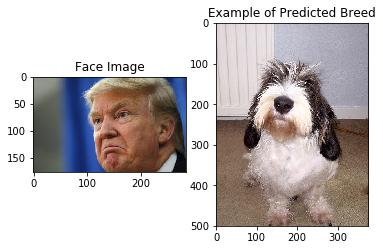

You look like a:  Petit_basset_griffon_vendeen



testrun/me_pic.jpg file_path
Hello human!


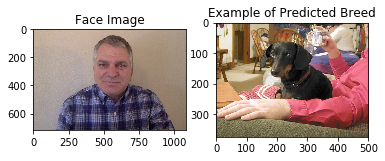

You look like a:  Dachshund



testrun/jack_russell3.jpg file_path
Hello dog


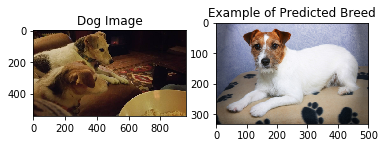

Your breed is likely:  Parson_russell_terrier



testrun/bear.jpeg file_path
Hello Neither Human or Dog!
Chinese_shar-pei


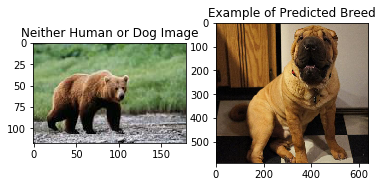

This image(neither human or dog) most resembles a:  Chinese_shar-pei



testrun/mop.jpeg file_path
Hello Neither Human or Dog!
Komondor


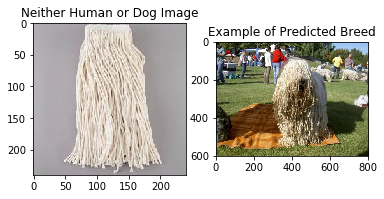

This image(neither human or dog) most resembles a:  Komondor



testrun/trumpbaldwin.jpeg file_path
Hello human!


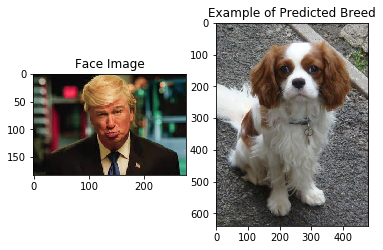

You look like a:  Cavalier_king_charles_spaniel



testrun/boxer.jpg file_path
Hello dog


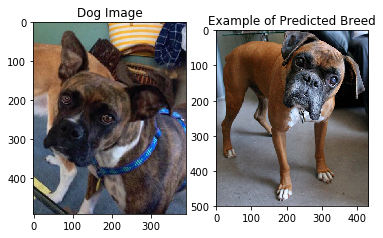

Your breed is likely:  Boxer



testrun/grey_hound3.jpg file_path
Hello dog


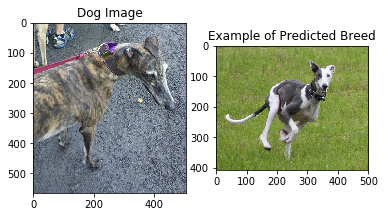

Your breed is likely:  Greyhound



testrun/George.jpg file_path
Hello dog


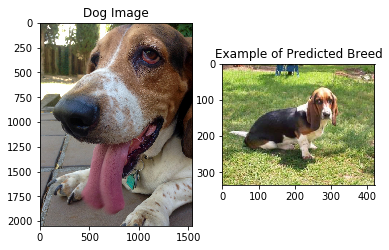

Your breed is likely:  Basset_hound



testrun/Australian-Shepherd-1.jpg file_path
Hello dog


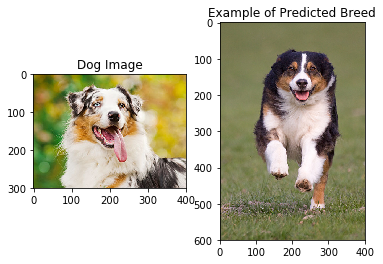

Your breed is likely:  Australian_shepherd



testrun/dash.jpg file_path
Hello dog


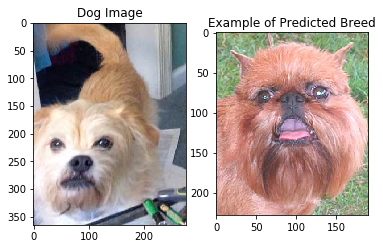

Your breed is likely:  Brussels_griffon


In [50]:
from glob import glob

testrun_files = np.array(glob("testrun/*"))
random.shuffle(testrun_files)
print('There are %d total testrun_files images.' % len(testrun_files))

tester( testrun_files  ) 

### Resources

(1) https://classroom.udacity.com/nanodegrees/nd009/parts/99115afc-e849-48cf-a580-cb22eea2ba1b/modules/777db663-2b0d-4040-9ae4-bf8c6ab8f157/lessons/52fc79a7-13ff-4065-b3c6-8203ec9ef60c/concepts/9cf863c1-e33a-41c8-a3de-43eb6e536071

(2) https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html    
    
(3) https://github.com/udacity/aind2-cnn/blob/master/cifar10-augmentation/cifar10_augmentation.ipynb
 
(4) https://keras.io/applications/
    
(5) https://gist.github.com/fchollet/7eb39b44eb9e16e59632d25fb3119975
    
(6) https://classroom.udacity.com/nanodegrees/nd009/parts/99115afc-e849-48cf-a580-cb22eea2ba1b/modules/777db663-2b0d-4040-9ae4-bf8c6ab8f157/lessons/52fc79a7-13ff-4065-b3c6-8203ec9ef60c/concepts/a2bd1e2d-ad39-406f-a8de-81b599d22afb